In [31]:
import pandas as pd

proteins = pd.read_csv("../data/enzymes/proteins.csv")
proteins = proteins[proteins["#Peptides"] >= 50]
proteins["Accession"] = proteins["Accession"].apply(
    lambda x: x.split("|")[1].split("_")[0]
)
proteins.head(3)

,Protein Group,Protein ID,Accession,-10lgP,Coverage (%),Coverage (%) cht1,Coverage (%) cht2,Coverage (%) cht3,Coverage (%) cht4,Coverage (%) cht5,...,#Spec trp4,#Spec trp5,#Spec trp6,#Spec trp7,#Spec trp8,#Spec trp9,#Spec trp10,PTM,Avg. Mass,Description
0,2,7,AHNK,404.88,67,2,3,3,3,3,...,295,316,245,267,310,356,349,NaN,629114,Neuroblast differentiation-associated protein ...
1,7,3,CH60,379.98,94,55,71,71,64,69,...,73,89,78,79,87,115,110,NaN,61055,60 kDa heat shock protein mitochondrial OS=Ho...
2,10,23,BIP,355.27,93,50,69,66,68,64,...,77,82,72,75,87,89,91,NaN,72333,Endoplasmic reticulum chaperone BiP OS=Homo sa...


In [32]:
def remove_ends(peptide):
    if peptide[1] == ".":
        peptide = peptide[2:]
    if peptide[-2] == ".":
        peptide = peptide[:-2]
    return peptide


df = pd.read_csv("../data/enzymes/protein-peptides.csv")

df["Protein Accession"] = df["Protein Accession"].apply(
    lambda x: x.split("|")[1].split("_")[0]
)

df = df[df["Protein Accession"].isin(proteins["Accession"])]

df["Peptide"] = df["Peptide"].apply(remove_ends)

samples = [col for col in df.columns if col.startswith("#Featu") and col != "#Feature"]
df.set_index(["Protein Accession", "Peptide"], inplace=True)
df = df[samples]

import numpy as np

# df = df.apply(np.log2).fillna(0).replace(-np.inf, 0)
df

#Feature cht1  #Feature cht2  \
Protein Accession Peptide                                                     
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK              0              0   
                  HELTEISNVDVETQSGK                        0              0   
                  IKGDVPSVGLEGPDVDLQGPEAK                  0              0   
                  GPHVDVSGPDIDIEGPEGK                      0              0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK                0              0   
...                                                      ...            ...   
AHNK2             TRLEGDL                                  0              0   
                  EATEVTLK                                 0              0   
                  GDLKNTDISIEPPS                           0              0   
                  MISSSVNVL                                0              0   
                  LQMPSFK                                  0              0   

                                               #Feature cht3  #Feature cht4  \
Protein Accession Peptide                                                     
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK              0              0   
                  HELTEISNVDVETQSGK                        0              0   
                  IKGDVPSVGLEGPDVDLQGPEAK                  0              0   
                  GPHVDVSGPDIDIEGPEGK                      0              0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK                0              0   
...                                                      ...            ...   
AHNK2             TRLEGDL                                  0              0   
                  EATEVTLK                                 0              0   
                  GDLKNTDISIEPPS                           0              0   
                  MISSSVNVL                                0              0   
                  LQMPSFK                                  0              0   

                                               #Feature cht5  #Feature cht6  \
Protein Accession Peptide                                                     
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK              0              0   
                  HELTEISNVDVETQSGK                        0              0   
                  IKGDVPSVGLEGPDVDLQGPEAK                  0              0   
                  GPHVDVSGPDIDIEGPEGK                      0              0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK                0              0   
...                                                      ...            ...   
AHNK2             TRLEGDL                                  0              0   
                  EATEVTLK                                 0              0   
                  GDLKNTDISIEPPS                           0              0   
                  MISSSVNVL                                0              0   
                  LQMPSFK                                  0              0   

                                               #Feature cht7  #Feature cht8  \
Protein Accession Peptide                                                     
AHNK              SKGHYEVTGSDDETGKLQGSGVSLASK              0              0   
                  HELTEISNVDVETQSGK                        0              0   
                  IKGDVPSVGLEGPDVDLQGPEAK                  0              0   
                  GPHVDVSGPDIDIEGPEGK                      0              0   
                  ADVDVSGPKVDVEGPDVNIEGPEGK                0              0   
...                                                      ...            ...   
AHNK2             TRLEGDL                                  0              0   
                  EATEVTLK                                 0              0   
                  GDLKNTDISIEPPS                           0              0   
                  MISSSVNVL                                0              0   
               

In [3]:
samples_split = [s.split(" ")[1] for s in samples]

import re

pattern = r"[0-9]"

groups = [re.sub(pattern, "", s) for s in samples_split]

design = pd.DataFrame({"sample": samples_split, "group": groups})
design.to_csv("../data/enzymes/design.csv")

In [4]:
import seaborn as sns

sq = (
    df.reset_index()
    .drop(columns="Protein Accession")
    .rename(columns={"Peptide": "sample"})
    .set_index("sample")
    .T
)
sq.index = [s.split(" ")[1] for s in sq.index]
sq = sq.merge(design, left_index=True, right_on="sample").set_index(["sample", "group"])

# sns.clustermap(sq)

In [5]:
data_dict = {}

for sample in samples:
    sample_data = df[sample].dropna().reset_index()
    protein_dict = {}
    for protein in sample_data["Protein Accession"].unique():
        protein_data = sample_data[sample_data["Protein Accession"] == protein]
        peptide_dict = {}

        for i, row in protein_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


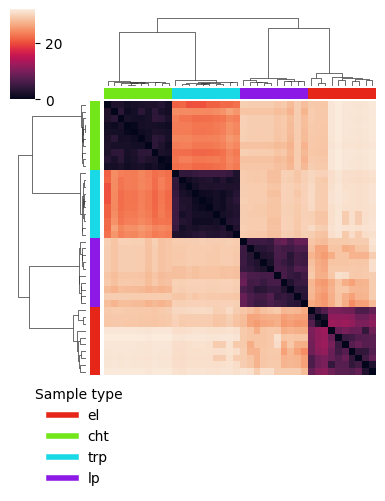

In [6]:
from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare


protein = "H4"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [7]:
df = df.rename(columns={s1: s2 for s1, s2 in zip(samples, samples_split)})

In [8]:
df.to_csv("../data/enzymes/processed.csv")

# Get param values for gamma

in vitro 1.438694550365602 6.776824404926209 4.564749111402035
in vivo 1.9155386766281643 6.463266107715064 4.557523852970956


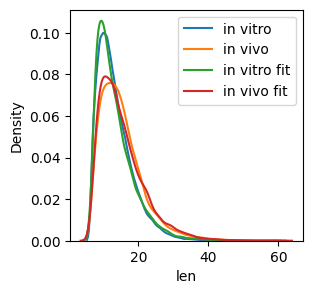

In [35]:
df.reset_index(inplace=True)

pig_df = pd.read_csv(
    "https://raw.githubusercontent.com/ErikHartman/pepnets/main/data/data.csv"
)
pig_df["len"] = pig_df["Peptide"].apply(lambda x: len(x))
df["len"] = df["Peptide"].apply(lambda x: len(x))

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

pig_samples = [col for col in pig_df.columns if col.startswith("Sample")]
len_pig_df = pig_df[pig_samples + ["len"]].set_index("len").stack().reset_index().rename(columns={0:"count"})

len_df = df[samples + ["len"]].set_index("len").stack().reset_index().rename(columns={0:"count"})

fit_alpha, fit_loc, fit_beta = stats.gamma.fit(df["len"])

print("in vitro", fit_alpha, fit_loc, fit_beta)
data = stats.gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

fit_alpha, fit_loc, fit_beta = stats.gamma.fit(pig_df["len"])

print("in vivo", fit_alpha, fit_loc, fit_beta)
pig_data = stats.gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

plt.figure(figsize=(3,3))

sns.kdeplot(df, x="len", label="in vitro")
sns.kdeplot(pig_df, x="len", label="in vivo")
sns.kdeplot(data, label="in vitro fit")
sns.kdeplot(pig_data, label="in vivo fit")
plt.legend()

In [ ]:
s = ""
for peptide in pig_df["Peptide"].unique():
    s += f">{peptide}\n{peptide}\n"

with open("../pig_fasta.fasta", "w") as f:
    f.write(s)